Lagrangian Tracer Bloom Model
==

Based on v00, not clear exactly what has changed aside from pointing to bloom_tracers_v01
rather than bloom_tracers_v09.

Later updated to point to newer bloom_tracers_v10 run.

In [14]:
import matplotlib.pyplot as plt
%matplotlib widget

In [15]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")
from stompy import utils
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
from stompy.plot import plot_utils, plot_wkb
from stompy.grid import unstructured_grid
from matplotlib import colors
import pandas as pd
import os
import numpy as np
import xarray as xr
import subprocess
from scipy.integrate import solve_ivp
from numba import njit
from stompy.spatial import field
from scipy import ndimage

from IPython.display import Video
import time
import six
import datetime
import glob
from stompy.plot import nbviz

In [16]:
# These online-coupled dfm-dwaq runs.

# Spinup
#run_dir="bloom_tracers_v01/run_20220801T0000_20220804T0000_v01"
# Main run
#run_dir="bloom_tracers_v01/run_20220804T0000_20220830T0000_v00"

# 2024-06-28: improved temperature field, 3 choices of swimming
#run_dir="bloom_tracers_v09/run_20220804T1820_20220830T0000_v01"
#swim_speeds=[5,10,0]

# 2024-07-10ish: fix bug in initial condition, small and large release from RS.
# Failed 3 days early due to full disk.
#run_dir="bloom_tracers_v10/run_20220804T1820_20220830T0000_v00"
#swim_speeds=[5,10,0,5,10,0]
#initial_conds=['alameda','alameda','alameda','southbay','southbay','southbay']

# no temperature run -- only 5 days in as of 2024-07-23
# run_dir="bloom_tracers_v11/run_20220804T1820_20220830T0000_v00"
# swim_speeds=[5,10,0,5,10,0]
# initial_conds=['alameda','alameda','alameda','southbay','southbay','southbay']


# 2024-08-30: v12 -- lots of tracers, uniform and chl_from_rs
run_dir="bloom_tracers_v12/run_20220804T1820_20220830T0000_v00"
swim_speeds=[5,10,0,6.912,6.912j,
             5,10,0,6.912,6.912j] # imaginary implies diurnal 
initial_conds=['alameda','alameda','alameda','alameda','alameda',
               'uniform','uniform','uniform','uniform','uniform']


model=dfm.DFlowModel.load(run_dir)

In [17]:
ds=model.map_dataset()

In [18]:
ds.reload()

In [19]:
grid=ds.grid
grid_poly=grid.boundary_polygon()

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3212664407.249223, 15 potential interiors


In [20]:
def ratio(a,b,b_min=1e-8):
    a_b = a/b.clip(b_min)
    # avoid using np.where, since it loses xarray dimensions.
    a_b[b<b_min] = np.nan
    return a_b

In [21]:
frac=0.1
M=grid.smooth_matrix()
def fill(values,iterations=50):
    valid=np.isfinite(values)
    data=np.where(valid,values,0.0)
    weight=np.where(valid,1,0.0)
    for _ in range(iterations):
        data=M.dot(data)
        weight=M.dot(weight)
        data[valid]=values[valid]
        weight[valid]=1.0
    result=np.full(len(values),np.nan)
    valid=weight>1e-4
    result[valid]=data[valid]/weight[valid]
    return result

INFO:utils:84902/86633


Checking swim results
--

Looks like setting swimming via DFM is working, and the age/depth/radiation tracers
give reasonable results.

In [22]:
sample_xy = [561890, 4173260]
c=ds.grid.select_cells_nearest(sample_xy) # 24893

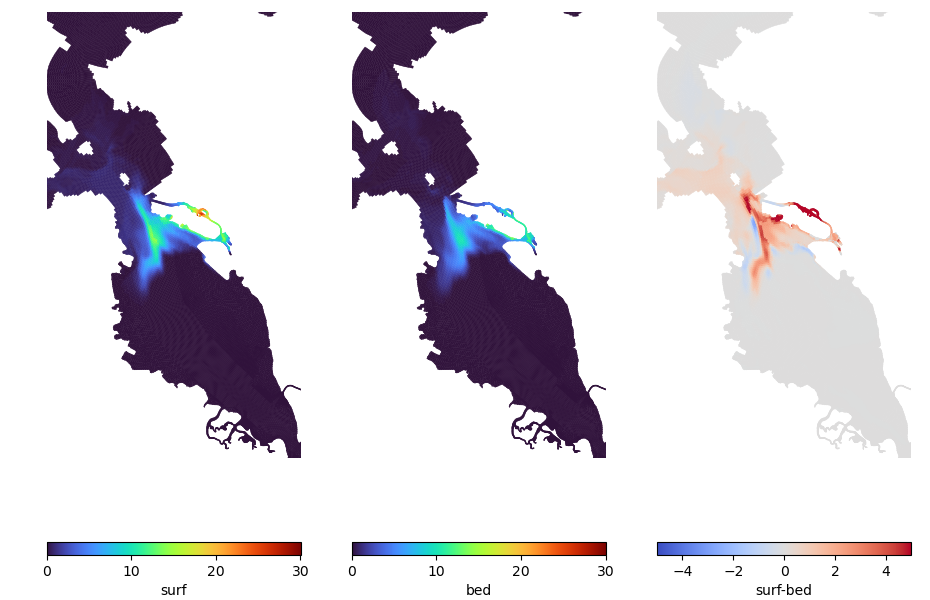

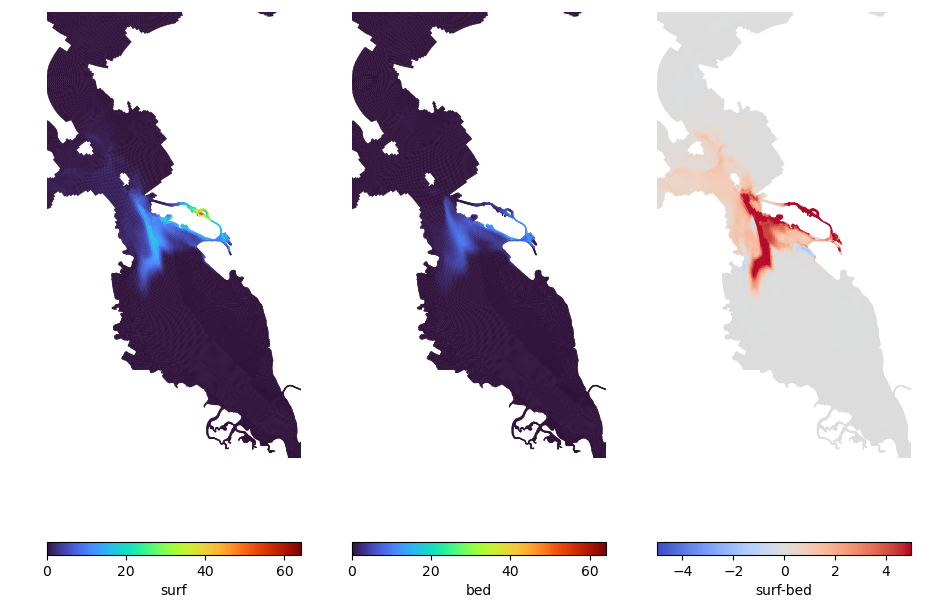

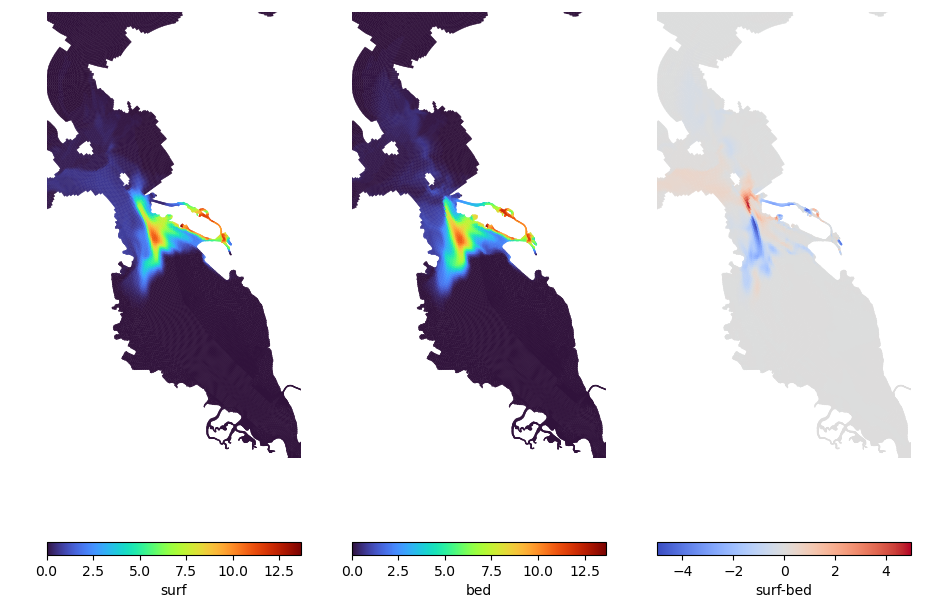

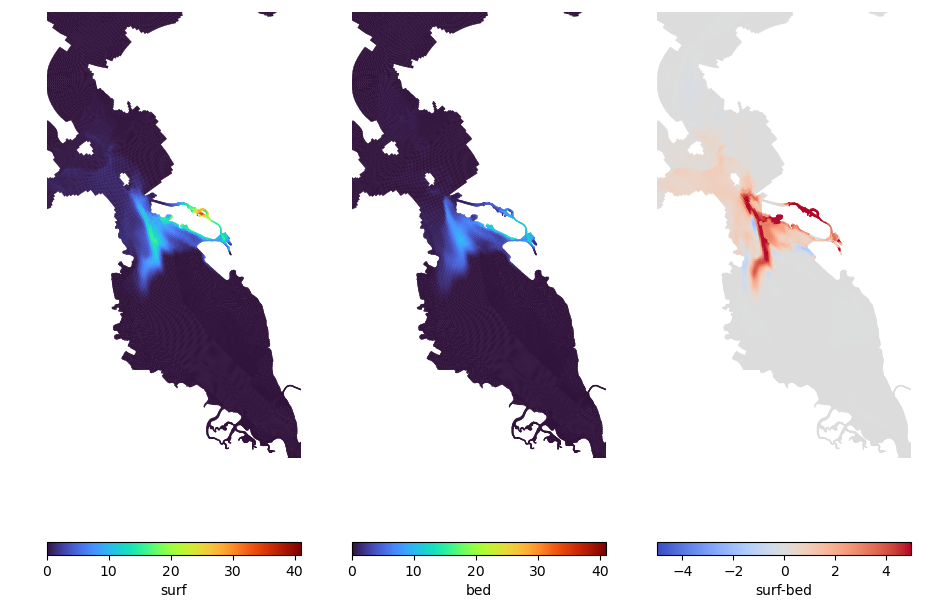

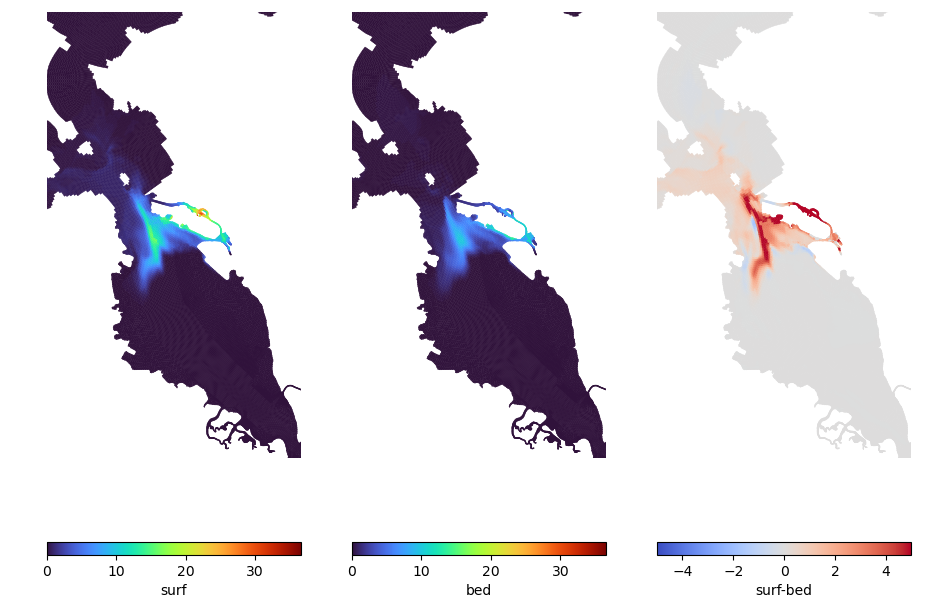

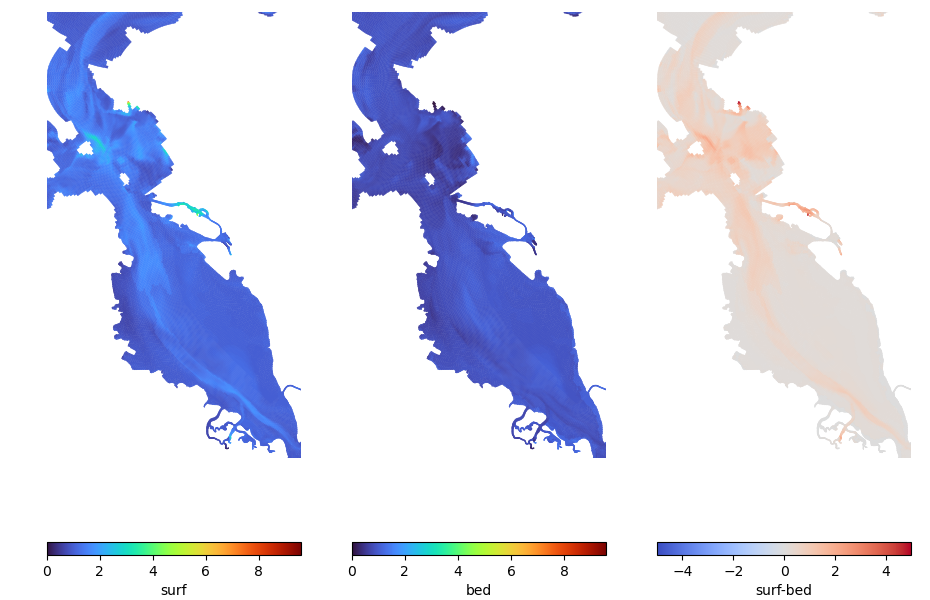

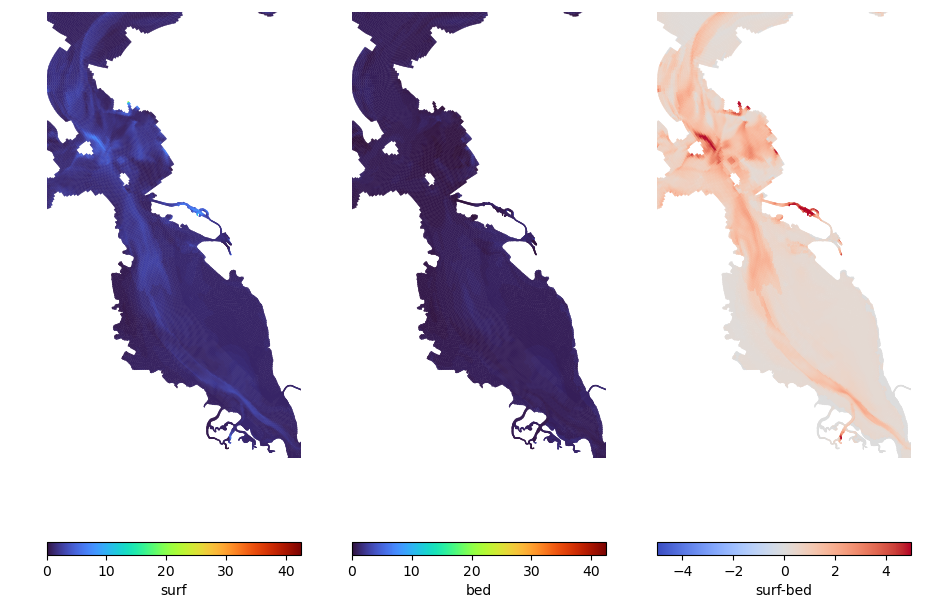

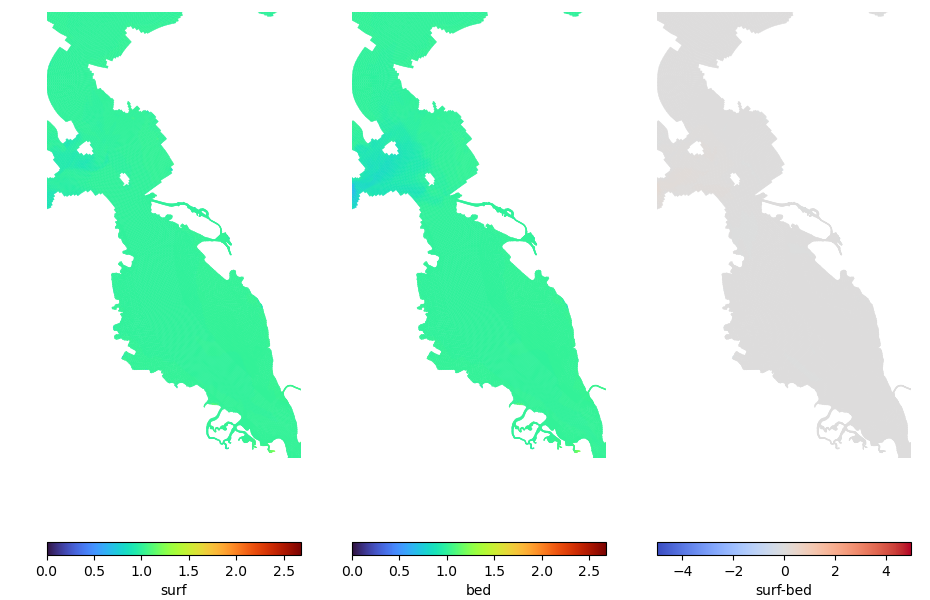

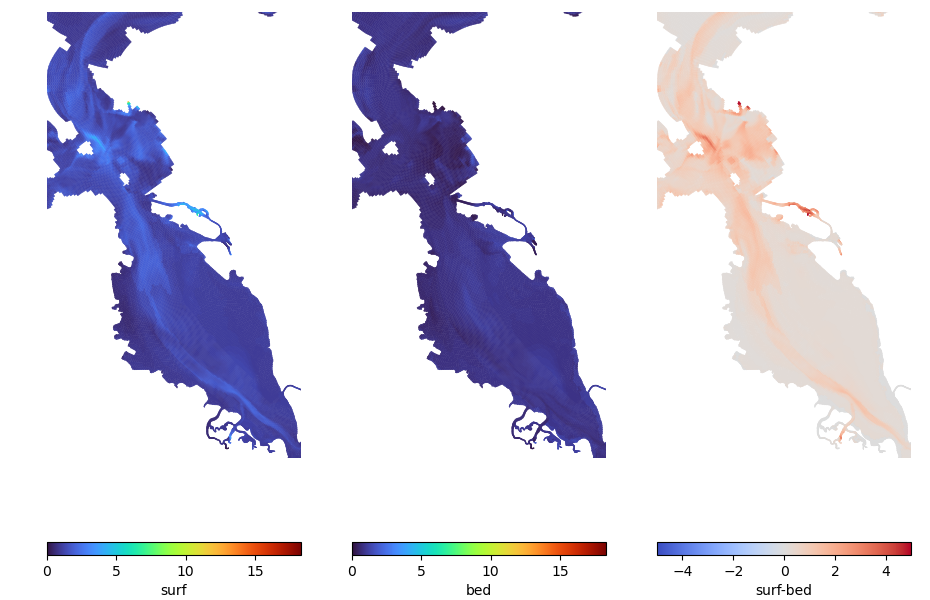

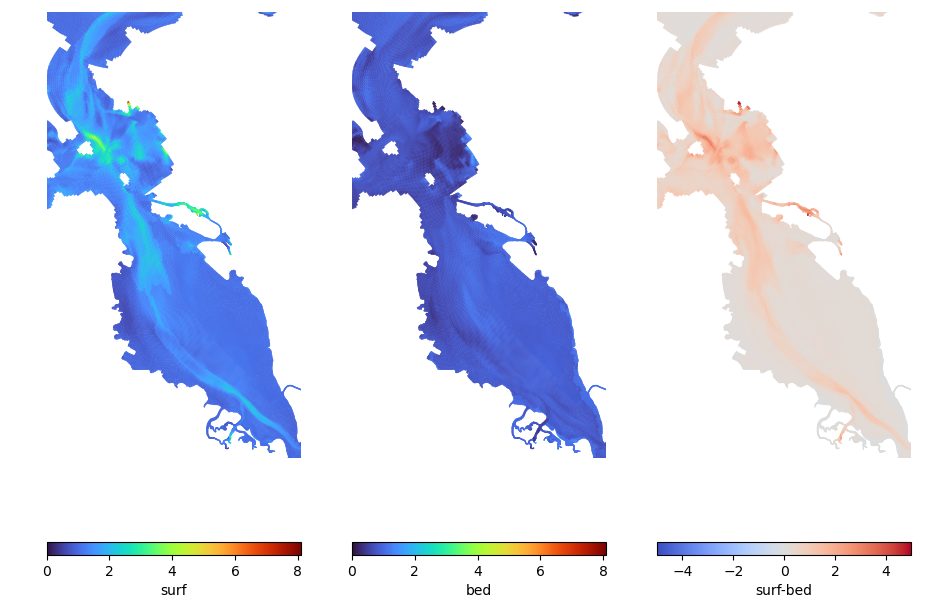

In [56]:
# v12 runs: map-view of various tracers
from matplotlib import colors
zoom=(544771.5497269231, 579151.3071774896, 4152713.959981727, 4205162.945208706)

def fig_snap(v):
    tidx=100
    scal_surf = ds[v].isel(time=tidx,laydim=-1).values
    scal_bed  = ds[v].isel(time=tidx,laydim=0).values

    fig,axs = plt.subplots(1,3, figsize=(9.3,6))
    for ax in axs:
        ax.set_adjustable('datalim')
        ax.axis('off')

    kw=dict(lw=0.3,edgecolor='face')
    cbkw=dict(orientation='horizontal',fraction=0.05)
    
    coll0 = ds.grid.plot_cells(values=scal_surf, ax=axs[0], cmap='turbo',**kw)
    plt.colorbar(coll0,label='surf',ax=axs[0],**cbkw)
    coll1 = ds.grid.plot_cells(values=scal_bed, ax=axs[1], cmap='turbo', norm=coll0.norm, **kw)
    plt.colorbar(coll1,label='bed',ax=axs[1],**cbkw)
    coll2 = ds.grid.plot_cells(values=scal_surf-scal_bed, ax=axs[2], cmap='coolwarm', 
                               norm=colors.CenteredNorm(0,5),
                              **kw)
    plt.colorbar(coll2,label='surf-bed',ax=axs[2],**cbkw)
    for ax in axs:
        ax.axis(zoom)
    fig.subplots_adjust(left=0.05,right=0.98,bottom=0.05,top=0.98)
    return fig
    
fig=fig_snap('conc0')
fig=fig_snap('conc1')
fig=fig_snap('conc2')
fig=fig_snap('conc3')
fig=fig_snap('conc4')
fig=fig_snap('conc5')
fig=fig_snap('conc6')
fig=fig_snap('conc7')
fig=fig_snap('conc8')
fig=fig_snap('conc9')


In [53]:

if 0:
    # Check to see whether upward swimming is working, and if age/property tracers are working.
    point=[557240,4185530] # SE of Treasure Island.
    c=ds.grid.select_cells_nearest(point)
    
    conc0_tz = ds['conc0'].isel(nFlowElem=c)
    conc1_tz = ds['conc1'].isel(nFlowElem=c)
    z=-ds['FlowElem_zcc'].isel(nFlowElem=c) + ds['LayCoord_cc'] * ds['waterdepth'].isel(nFlowElem=c)
    
    fig,axs=plt.subplots(2,1,sharex=True,sharey=True)
    colls=[]
    for ax,conc in zip(axs,[conc0_tz,conc1_tz]):
        colls.append( plot_utils.pad_pcolormesh( conc.time, z, conc.values.T, cmap='turbo', shading='flat', ax=ax) )
    colls[0].set_clim( colls[1].get_clim() )
    plt.colorbar( colls[0], ax=axs, label="Conc")

In [31]:
# Similar, but check on age
# v09: no age process?
if 0:
    if 'agec0' in ds:
        agec0 = ds['agec0'].isel(nFlowElem=c)
        conc0 = ds['conc0'].isel(nFlowElem=c)
        age0=ratio(agec0, conc0, 1e-5)
        ages=[age0]
    
        z=-ds['FlowElem_zcc'].isel(nFlowElem=c) + ds['LayCoord_cc'] * ds['waterdepth'].isel(nFlowElem=c)
        
        if 'agec1' in ds:
            agec1 = ds['agec1'].isel(nFlowElem=c)
            age1=ratio(agec1, conc1_tz, 1e-5)
            ages.append(age1)
            
        fig,axs=plt.subplots(len(ages),1,sharex=True,sharey=True,squeeze=False)
        colls=[]
        for ax,age in zip(axs[:,0],ages):
            colls.append( plot_utils.pad_pcolormesh( ds.time, z, age.values.T, cmap='turbo', shading='flat',ax=ax) )
            if len(colls)>1:
                colls[-1].set_clim( colls[0].get_clim() )
        plt.colorbar( colls[0], ax=axs, label="age")
    else:
        print("This run doesn't have age")

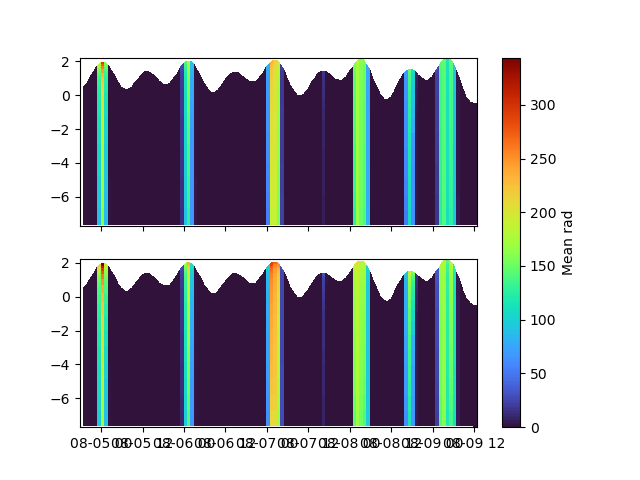

In [32]:
# Similar, but check on rad.
radc0 = ds['radc0'].isel(nFlowElem=c)
radc1 = ds['radc1'].isel(nFlowElem=c)
z=-ds['FlowElem_zcc'].isel(nFlowElem=c) + ds['LayCoord_cc'] * ds['waterdepth'].isel(nFlowElem=c)

age_exact = ((ds.time - ds.time.values[0]) / np.timedelta64(86400,'s'))
rad0=ratio(radc0, age_exact, 1e-5)
rad1=ratio(radc1, age_exact, 1e-5)

fig,axs=plt.subplots(2,1,sharex=True,sharey=True)
colls=[]
for ax,rad in zip(axs,[rad0,rad1]):
    colls.append( plot_utils.pad_pcolormesh( ds.time, z, rad.values.T, cmap='turbo', shading='flat',ax=ax) )
colls[0].set_clim( colls[1].get_clim() )
plt.colorbar( colls[0], ax=axs, label="Mean rad")

In [58]:
# Lastly, mean depth
if 'depc0' in ds:
    depc0 = ds['depc0'].isel(nFlowElem=c)
    depc1 = ds['depc1'].isel(nFlowElem=c)
    
    dep0=ratio(depc0, agec0, 1e-5)
    dep1=ratio(depc1, agec1, 1e-5)
    
    fig,axs=plt.subplots(2,1,sharex=True,sharey=True)
    colls=[]
    for ax,dep in zip(axs,[dep0,dep1]):
        colls.append( ax.pcolormesh( ds.time, z, dep.values.T, cmap='turbo', shading='nearest') )
    colls[0].set_clim( colls[1].get_clim() )
    plt.colorbar( colls[0], ax=axs, label="Mean depth")

Plotting All Fields
--

In [57]:
tidx=0

def rad_fn(snap,g):
    return property_fn(snap,g,'radc')
def dep_fn(snap,g):
    return property_fn(snap,g,'radc')

def snap_t(snap):
    return (snap.time - ds.time.isel(time=0))/np.timedelta64(86400,'s')
    
def property_fn(snap,g,property):
    v=f'agec{g}'
    if v in snap:
        return ratio( snap[f'{property}{g}'].compute(), snap[v].compute(), 1e-5)
    else:
        return ratio( snap[f'{property}{g}'], snap[f'conc{g}']*snap_t(snap), 1e-5)

def age_fn(snap,g):
    v=f'agec{g}'
    if v in snap:
        return ratio(snap[f'agec{g}'].values, snap[f'conc{g}'].values,1e-5)
    else:
        return 0*snap[f'conc{g}'] + snap_t(snap)

plots=[
    dict(label='$log_{10}$ Conc', clim=[-4,0], data_fn=lambda snap,g: np.log10(snap[f'conc{g}'].values.clip(1e-4))),
    #dict(label='Average rad', clim=[10,30],data_fn=rad_fn),
    #dict(label="Depth exposure (m)", clim=[0,10], data_fn=dep_fn),    
    #dict(label="Age (d)", clim=[0,15], data_fn=age_fn),         
]

if 0:
    snap2d=ds.isel(time=tidx,laydim=-1)
    
    group_sel=[1,4]
    
    for plot in plots: 
        fig,axs=plt.subplots(1,len(group_sel),figsize=(10,4))
        for g,ax in enumerate(axs):
            grp = group_sel[g]
            ax.set_adjustable('datalim')
            fig.subplots_adjust(left=0.01, right=0.94, top=0.98, bottom=0.02)
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)    
            kw=dict(lw=0.5,edgecolor='face', cmap='turbo')    
            scal=plot['data_fn'](snap2d,grp) 
                    
            ccoll=ds.grid.plot_cells( values=scal, clim=plot['clim'], ax=ax, **kw)
            plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax)
            ax.axis((532541.1781775085, 575394.0337062994, 4160999.923094737, 4202393.6312130485))
            ax.text(0.0,1.0, utils.strftime(snap2d.time.values), transform=ax.transAxes,va='top',
                    bbox=dict(fc='w', ec='k',lw=0.5))
        plt.colorbar(ccoll,label=plot['label'],ax=axs,fraction=0.05)


In [59]:
from stompy import memoize

@memoize.memoize(lru=1)
def extract_tracers(tidx,layer,Isat=10.0,thresh=1e-5,group=0):
    # Extraction
    # instantaneous release, so age is a given.
    t=ds.time.isel(time=tidx).values
    age_d = (t - ds.time.values[0]) / np.timedelta64(86400,'s')
    
    if layer=='mean':
        snap=ds.isel(time=tidx)
        conc = snap[f'conc{group}'].values.mean(axis=1).clip(0,np.inf)

        # These should be about the same, not sure why one would be preferable over the
        # other.
        #Imean =  ratio( snap['radc0'].values, snap['agec0'].values, thresh)
        Imean = ratio( snap[f'radc{group}'].values, snap[f'conc{group}'].values*age_d, thresh)
            
        kLight = (Imean/(Imean + Isat)).mean(axis=1) # happen to know that layer is the second dimension    
    else:
        snap=ds.isel(time=tidx,laydim=layer)
        conc  = snap[f'conc{group}'].values
    
        # average irradiance accounting for Kd, vertical mixing.
        Imean = ratio( snap[f'radc{group}'].values, snap[f'conc{group}'].values*age_d, thresh)
        # This could be averaged over the layers instead.
        kLight = Imean/(Imean + Isat)

    #Imean[np.isnan(Imean)]=0.0 
    #kLight = fill(kLight, iterations=120)
    print(f"kLight: {np.isnan(kLight).sum()} missing values, thresh={thresh}")
    return dict(age_d=age_d, conc=conc, kLight=kLight, Imean=Imean, t=t)  


In [60]:
# Panel for P and a panel for N.

def solveNP(thresh=1e-5,
            # Parameters:
            c0 = 50,
            tidx = 20, 
            Isat=20., 
            N0=35, # initial DIN
            Nsat=0.5,
            kprod=0.7, # per day. high!
            kmort=0.1,
            alpha=0.15, # stoichiometry, uM DIN per ug/l chl production.
            layer='mean',
            group=0):
    tracers=extract_tracers(tidx=tidx, layer=layer, Isat=Isat, thresh=thresh, group=group)
    kLight = tracers['kLight']
    conc = c0*tracers['conc']
    age_d = tracers['age_d']
    Imean = tracers['Imean']
    t = tracers['t']

    sel = np.isfinite(kLight * conc * age_d)
    kLight = kLight[sel]
        
    # ODE integration
    # State vector is [ P[0].... P[i], N[0], ... , N[i] ]
    def diff(t,state):
        P,N=state.reshape([2,-1])
        N=N.clip(0) # no evidence this is really necessary
        P=P.clip(0) # likewise.
        kDIN=N/(N+Nsat)
        dgrossP = kprod*kLight*kDIN*P
        dnetP = -kmort*P + dgrossP
        dN = -alpha*dgrossP
        mu_net = kprod*kLight*kDIN - kmort
        return np.r_[dnetP,dN]
    IC=np.r_[conc[sel], N0*np.ones_like(conc)[sel]]

    print("IC shape: ", IC.shape) # 2*Ncells
    
    # odeint was buggy.
    #result = odeint(diff, IC, [0,age_d], hmax=0.1)
    bunch = solve_ivp(diff, y0=IC, t_span=[0,age_d])
    result=bunch.y[:,-1]
    Psel,Nsel = result.reshape([2,-1])
    # expand
    if 1:
        # assume no biomass, no depletion of N when conc too small.
        P = np.full(conc.shape,0.0)
        N = np.full(conc.shape,N0)
    else:
        # Make it clear where data is missing
        P = np.full(conc.shape,np.nan)
        N = np.full(conc.shape,np.nan)
        
    P[sel]=Psel
    N[sel]=Nsel
    
    ds=xr.Dataset()
    ds['N'] = ('cell',), N
    ds['P'] = ('cell',), P
    ds['time'] = (),t

    ds['c0'] = (),c0
    ds['Isat'] = (),Isat
    ds['N0'] = (),N0
    ds['Nsat'] = (),Nsat
    ds['kprod'] = (), kprod
    ds['kmort'] = (), kmort
    ds['alpha'] = (), alpha
    ds['layer'] = (), layer
    
    return ds

In [61]:
import stompy.plot.cmap as scmap
import matplotlib.colorbar as cbar

from matplotlib import cm
turbo_low = scmap.cmap_transform(cm.turbo,lambda i: i**0.75)

In [66]:
#rs_chl_dir="/richmondvol1/lawrences/outputs_2022/07_reproject_3"

# 2024-09-11: 07_reproject_3 no longer exists.
#rs_chl_dir="/richmondvol1/lawrences/outputs_2022/07_reproject_3"
# Assuming this is best to use:
rs_chl_dir="/richmondvol1/lawrences/outputs_2022/07_reproject_re10_sfei"


def chl_from_RS(t):
    #scene="20220804_S3A_OL_NT_CHL_LOG10.img" # bloom not that obvious.
    #scene="20220805_S3B_OL_NT_CHL_LOG10.img" # lots of clouds
    #scene="20220806_S3B_OL_NT_CHL_LOG10.img" # lots of clouds

    patt = os.path.join(rs_chl_dir, f"{utils.strftime(t,'%Y%m%d')}_S3*_OL_NT_CHL_LOG10.img")
    hits=glob.glob(patt)
    if not hits:
        return None
    #scene="20220807_S3A_OL_NT_CHL_LOG10.img" # decent, though getting late.
    #rs_chl_fn=os.path.join(rs_chl_dir,scene)
    rs_chl_fn=hits[0]
    rs_chl_log10 = field.GdalGrid(rs_chl_fn)
    
    # clip and remove specks.    
    valid = np.isfinite(rs_chl_log10.F)
    valid = valid & rs_chl_log10.polygon_mask(grid_poly) 
    rs_chl_log10.F[~valid]=np.nan
    rs_chl_log10.F = ndimage.median_filter(rs_chl_log10.F,size=3)
    # rs_chl_log10.F[ rs_chl_log10.F<1.0 ] = 0.0
        
    chl_IC = rs_chl_log10.copy()
    chl_IC.F = 10**chl_IC.F    
        
    return chl_IC

kLight: 31461 missing values, thresh=0.01
IC shape:  (37070,)


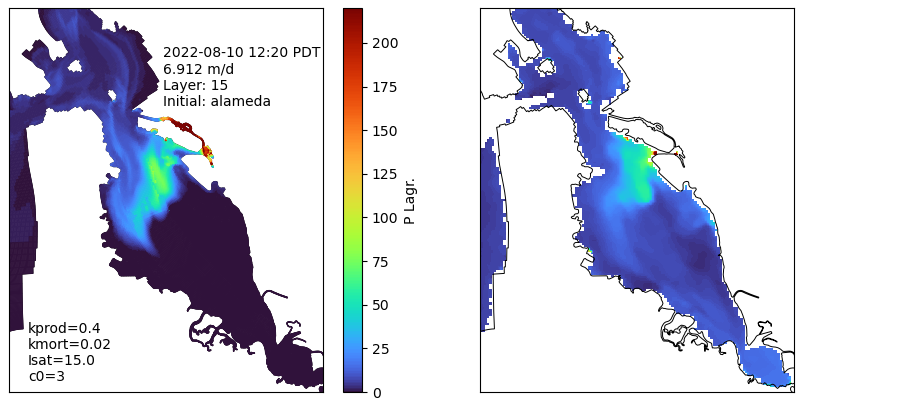

In [100]:
# Lagrangian vs. RS chl

#tidx=73 # 8/7 noon
#tidx=97 # 8/8
#tidx=121
tidx=145 # 8/10
#tidx=169 # 8/11
#tidx=193 # 8/12
#tidx=217 # 8/13
#tidx=241 # 8/14
#tidx=385 # 8/20
#tidx=409 # 8/21
#tidx=433 # 8/22 12:20

# What does it take to get a bloom if I apply the 0.4 attenuation factor
# for light distribution, and a fixed 0.7 g_max?

t=ds.time.values[tidx]

rs_chl = chl_from_RS(t)

for group in [3]: # [2,0,1]:
    for layer in [15]:
        result = solveNP(tidx=tidx, group=group, layer=layer, 
                         thresh=1e-2, 
                         c0=3, 
                         kprod=0.4, # 0.4*0.95,
                         N0=45, # initial DIN, uM
                         Nsat=0.5, # half-sat DIN, uM
                         kmort=0.02,
                         Isat=15.0)
        
        fig,axs=plt.subplots(1,2,figsize=(9,4))
        fig.subplots_adjust(left=0.01, right=0.97, top=0.98, bottom=0.02)
        axP,axRS = axs
        caxs=[cbar.make_axes(ax)[0] for ax in axs]
        
        kw=dict(lw=0.5,edgecolor='face')
        clim=[0,220]
        cmap=turbo_low

        for ax in axs:
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)    
            plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax)

        if 1: # Lagrangian model output
            ccoll=ds.grid.plot_cells( values=result.P, ax=axP, cmap=cmap, **kw)
            ccoll.set_clim(clim)
            plt.colorbar(ccoll,label='P Lagr.',ax=axP,cax=caxs[0])

            if np.isreal(swim_speeds[group]):
                swimming=f"{swim_speeds[group]} m/d"
            else:
                swimming=f"{np.imag(swim_speeds[group])} m/d diurnal"
                
            txt="\n".join([utils.strftime(result.time-np.timedelta64(7,'h'))+" PDT",
                           swimming,
                           f"Layer: {layer}",
                           f"Initial: {initial_conds[group]}"])
            axP.text(0.49,0.9, txt, va='top',
                     transform=axP.transAxes)

            param_txt=[]
            for fld in ['kprod','kmort','Isat','c0']:
                param_txt.append( f"{fld}={result[fld].values}" )
            param_txt="\n".join(param_txt)
            axP.text(0.06,0.02, param_txt, va='bottom',
                     transform=axP.transAxes)
            
        if rs_chl is not None: # RS scene
            rs_chl.plot(ax=axRS,cmap=cmap,clim=clim)
            caxs[1].set_visible(0)
        else:
            axRS.text(0.5,0.5,"No RS data",transform=axRS.transAxes, ha='center')
            
        for ax in axs:
            ax.axis((540604.0430344798, 585428.0850690929, 4144192.2487012795, 4198977.188965806))


IC shape:  (89924,)


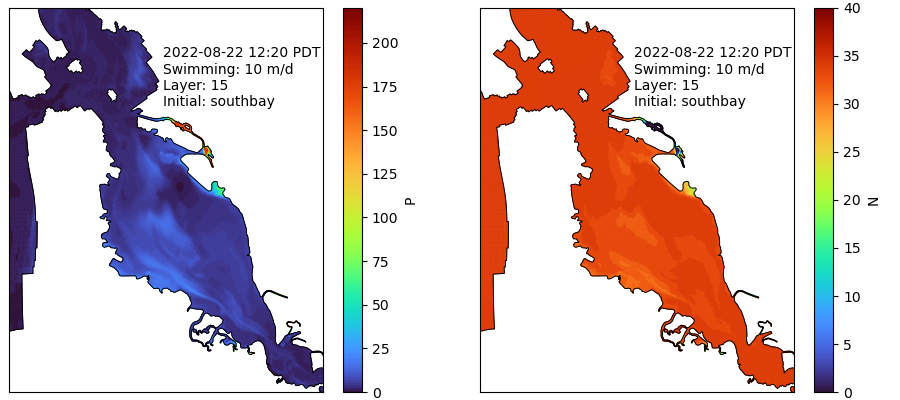

In [50]:

#tidx=97-24 # 8/7 noon
#tidx=97
#tidx=121
tidx=433 # 8/22 12:20

# What does it take to get a bloom if I apply the 0.4 attenuation factor
# for light distribution, and a fixed 0.7 g_max?

for group in [4]: # [2,0,1]:
    for layer in [15]:
        result = solveNP(c0=1.0, tidx=tidx, group=group, layer=layer, kprod=0.4*0.7, kmort=0.05,
                         thresh=1e-2)
        
        fig,axs=plt.subplots(1,2,figsize=(9,4))
        fig.subplots_adjust(left=0.01, right=0.97, top=0.98, bottom=0.02)
        axP,axN = axs
        caxs=[cbar.make_axes(ax)[0] for ax in axs]
        
        kw=dict(lw=0.5,edgecolor='face')
        
        for ax,cax,plot in zip(axs,caxs,[
            dict(scal=result.P,label='P',clim=[0,220],cmap=turbo_low),
            dict(scal=result.N,label='N',clim=[0,40],cmap='turbo')
        ]):
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)    
            ccoll=ds.grid.plot_cells( values=plot['scal'], ax=ax, cmap=plot['cmap'], **kw)
            ccoll.set_clim(plot['clim'])
            plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax)
            plt.colorbar(ccoll,label=plot['label'],cax=cax)
            # ax.axis((532541.1781775085, 575394.0337062994, 4160999.923094737, 4202393.6312130485))
            ax.axis((540604.0430344798, 585428.0850690929, 4144192.2487012795, 4198977.188965806))
            txt="\n".join([utils.strftime(result.time-np.timedelta64(7,'h'))+" PDT",
                           f"Swimming: {swim_speeds[group]} m/d",
                           f"Layer: {layer}",
                           f"Initial: {initial_conds[group]}"])
            ax.text(0.49,0.9, txt, va='top',
                    transform=ax.transAxes)

Group: 0  Output to bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_5mpd_ICalameda
   movie file: bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_5mpd_ICalameda/lagra_v00_5mpd_ICalameda.mp4
kLight: 49996 missing values, thresh=0.01
IC shape:  (0,)
kLight: 48751 missing values, thresh=0.01
IC shape:  (2490,)
kLight: 48498 missing values, thresh=0.01
IC shape:  (2996,)
kLight: 48236 missing values, thresh=0.01
IC shape:  (3520,)
kLight: 47966 missing values, thresh=0.01
IC shape:  (4060,)
kLight: 47715 missing values, thresh=0.01
IC shape:  (4562,)
kLight: 47566 missing values, thresh=0.01
IC shape:  (4860,)
kLight: 47438 missing values, thresh=0.01
IC shape:  (5116,)
kLight: 47398 missing values, thresh=0.01
IC shape:  (5196,)
kLight: 47439 missing values, thresh=0.01
IC shape:  (5114,)
kLight: 47512 missing values, thresh=0.01
IC shape:  (4968,)
kLight: 47570 missing values, thresh=0.01
IC shape:  (4852,)
kLight: 47630 missing values, thresh=0.01
IC sh

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Group: 1  Output to bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_10mpd_ICalameda
   movie file: bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_10mpd_ICalameda/lagra_v00_10mpd_ICalameda.mp4
kLight: 49996 missing values, thresh=0.01
IC shape:  (0,)
kLight: 48747 missing values, thresh=0.01
IC shape:  (2498,)
kLight: 48493 missing values, thresh=0.01
IC shape:  (3006,)
kLight: 48226 missing values, thresh=0.01
IC shape:  (3540,)
kLight: 47960 missing values, thresh=0.01
IC shape:  (4072,)
kLight: 47705 missing values, thresh=0.01
IC shape:  (4582,)
kLight: 47544 missing values, thresh=0.01
IC shape:  (4904,)
kLight: 47412 missing values, thresh=0.01
IC shape:  (5168,)
kLight: 47377 missing values, thresh=0.01
IC shape:  (5238,)
kLight: 47408 missing values, thresh=0.01
IC shape:  (5176,)
kLight: 47487 missing values, thresh=0.01
IC shape:  (5018,)
kLight: 47547 missing values, thresh=0.01
IC shape:  (4898,)
kLight: 47607 missing values, thresh=0.01
IC

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Group: 2  Output to bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_0mpd_ICalameda
   movie file: bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_0mpd_ICalameda/lagra_v00_0mpd_ICalameda.mp4
kLight: 49996 missing values, thresh=0.01
IC shape:  (0,)
kLight: 48757 missing values, thresh=0.01
IC shape:  (2478,)
kLight: 48506 missing values, thresh=0.01
IC shape:  (2980,)
kLight: 48245 missing values, thresh=0.01
IC shape:  (3502,)
kLight: 47976 missing values, thresh=0.01
IC shape:  (4040,)
kLight: 47731 missing values, thresh=0.01
IC shape:  (4530,)
kLight: 47585 missing values, thresh=0.01
IC shape:  (4822,)
kLight: 47466 missing values, thresh=0.01
IC shape:  (5060,)
kLight: 47425 missing values, thresh=0.01
IC shape:  (5142,)
kLight: 47465 missing values, thresh=0.01
IC shape:  (5062,)
kLight: 47547 missing values, thresh=0.01
IC shape:  (4898,)
kLight: 47603 missing values, thresh=0.01
IC shape:  (4786,)
kLight: 47661 missing values, thresh=0.01
IC sh

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Group: 3  Output to bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_5mpd_ICsouthbay
   movie file: bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_5mpd_ICsouthbay/lagra_v00_5mpd_ICsouthbay.mp4
kLight: 49996 missing values, thresh=0.01
IC shape:  (0,)
kLight: 46478 missing values, thresh=0.01
IC shape:  (7036,)
kLight: 46244 missing values, thresh=0.01
IC shape:  (7504,)
kLight: 45795 missing values, thresh=0.01
IC shape:  (8402,)
kLight: 45014 missing values, thresh=0.01
IC shape:  (9964,)
kLight: 44156 missing values, thresh=0.01
IC shape:  (11680,)
kLight: 43387 missing values, thresh=0.01
IC shape:  (13218,)
kLight: 42842 missing values, thresh=0.01
IC shape:  (14308,)
kLight: 42445 missing values, thresh=0.01
IC shape:  (15102,)
kLight: 42215 missing values, thresh=0.01
IC shape:  (15562,)
kLight: 41831 missing values, thresh=0.01
IC shape:  (16330,)
kLight: 41392 missing values, thresh=0.01
IC shape:  (17208,)
kLight: 40669 missing values, thresh=

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Group: 4  Output to bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_10mpd_ICsouthbay
   movie file: bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_10mpd_ICsouthbay/lagra_v00_10mpd_ICsouthbay.mp4
kLight: 49996 missing values, thresh=0.01
IC shape:  (0,)
kLight: 46459 missing values, thresh=0.01
IC shape:  (7074,)
kLight: 46222 missing values, thresh=0.01
IC shape:  (7548,)
kLight: 45767 missing values, thresh=0.01
IC shape:  (8458,)
kLight: 44964 missing values, thresh=0.01
IC shape:  (10064,)
kLight: 44085 missing values, thresh=0.01
IC shape:  (11822,)
kLight: 43314 missing values, thresh=0.01
IC shape:  (13364,)
kLight: 42737 missing values, thresh=0.01
IC shape:  (14518,)
kLight: 42329 missing values, thresh=0.01
IC shape:  (15334,)
kLight: 42112 missing values, thresh=0.01
IC shape:  (15768,)
kLight: 41777 missing values, thresh=0.01
IC shape:  (16438,)
kLight: 41342 missing values, thresh=0.01
IC shape:  (17308,)
kLight: 40624 missing values, thr

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Group: 5  Output to bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_0mpd_ICsouthbay
   movie file: bloom_tracers_v11/run_20220804T1820_20220830T0000_v00/frames_v00_0mpd_ICsouthbay/lagra_v00_0mpd_ICsouthbay.mp4
kLight: 49996 missing values, thresh=0.01
IC shape:  (0,)
kLight: 46494 missing values, thresh=0.01
IC shape:  (7004,)
kLight: 46270 missing values, thresh=0.01
IC shape:  (7452,)
kLight: 45850 missing values, thresh=0.01
IC shape:  (8292,)
kLight: 45071 missing values, thresh=0.01
IC shape:  (9850,)
kLight: 44220 missing values, thresh=0.01
IC shape:  (11552,)
kLight: 43471 missing values, thresh=0.01
IC shape:  (13050,)
kLight: 42955 missing values, thresh=0.01
IC shape:  (14082,)
kLight: 42562 missing values, thresh=0.01
IC shape:  (14868,)
kLight: 42299 missing values, thresh=0.01
IC shape:  (15394,)
kLight: 41913 missing values, thresh=0.01
IC shape:  (16166,)
kLight: 41449 missing values, thresh=0.01
IC shape:  (17094,)
kLight: 40725 missing values, thresh=

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

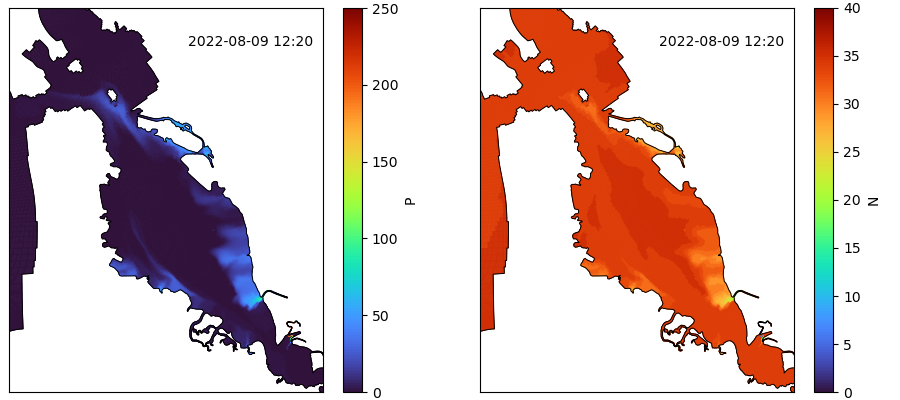

In [40]:
# Animation
fig,axs=plt.subplots(1,2,figsize=(9,4))
fig.subplots_adjust(left=0.01, right=0.97, top=0.98, bottom=0.02)
axP,axN = axs
caxs=[cbar.make_axes(ax)[0] for ax in axs]

for group in [0,1,2,3,4,5]:
    frame_dir=os.path.join(run_dir,f"frames_v00_{swim_speeds[group]}mpd_IC{initial_conds[group]}")
    movie_fn=os.path.join(frame_dir,f"lagra_v00_{swim_speeds[group]}mpd_IC{initial_conds[group]}.mp4")

    print(f"Group: {group}  Output to {frame_dir}")
    print(f"   movie file: {movie_fn}")
    updated=False
    if not os.path.exists(frame_dir):
        os.makedirs(frame_dir)
    
    for ax in axs:
        ax.set_adjustable('datalim')
        ax.xaxis.set_visible(0)
        ax.yaxis.set_visible(0)    
    
    for tidx in range(ds.dims['time']):
        img_fn=os.path.join(frame_dir,"frame_%04d.png"%tidx)
        if os.path.exists(img_fn):
            continue
            
        result = solveNP(tidx=tidx,group=group, c0=1.0, layer=15, kprod=0.6, kmort=0.05, thresh=1e-2)
    
        axP.cla()
        axN.cla()
        
        kw=dict(lw=0.5,edgecolor='face', cmap='turbo')
        
        for ax,cax,plot in zip(axs,caxs,[
            dict(scal=result.P,label='P',clim=[0,250]),
            dict(scal=result.N,label='N',clim=[0,40])
        ]):
            ax.cla()
            cax.cla()
            
            ccoll=ds.grid.plot_cells( values=plot['scal'], ax=ax,**kw)
            ccoll.set_clim(plot['clim'])
            plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax)
            plt.colorbar(ccoll,label=plot['label'],cax=cax)
            ax.axis((540604.0430344798, 585428.0850690929, 4144192.2487012795, 4198977.188965806))
            ax.text(0.57,0.9, utils.strftime(result.time), transform=ax.transAxes)
        fig.savefig(img_fn,dpi=100)
        updated=True


    # Compile to animation
    import subprocess
    if os.path.exists(movie_fn):
        if not updated:
            continue
        os.unlink(movie_fn)
    subprocess.run(f"ffmpeg -framerate 10 -i {os.path.join(frame_dir,'frame_%04d.png')} "
                    "-c:v libx264 -preset slow -profile:v high -level:v 4.0 "
                   f"-pix_fmt yuv420p -crf 20 -r 10 {movie_fn}",
                   shell=True)


In [57]:
# Thinking about distribution of insolation, and ways of approximating 
# synthesize time series of Rad
c=35119
Qsun=ds['Qsun'].isel(nFlowElem=c).values


In [62]:
depth = np.linspace(0,4,len(Qsun))
Kd=1.5
atten = np.exp(-depth*Kd)
rad_synth = Qsun * atten

Correction factor 0.400


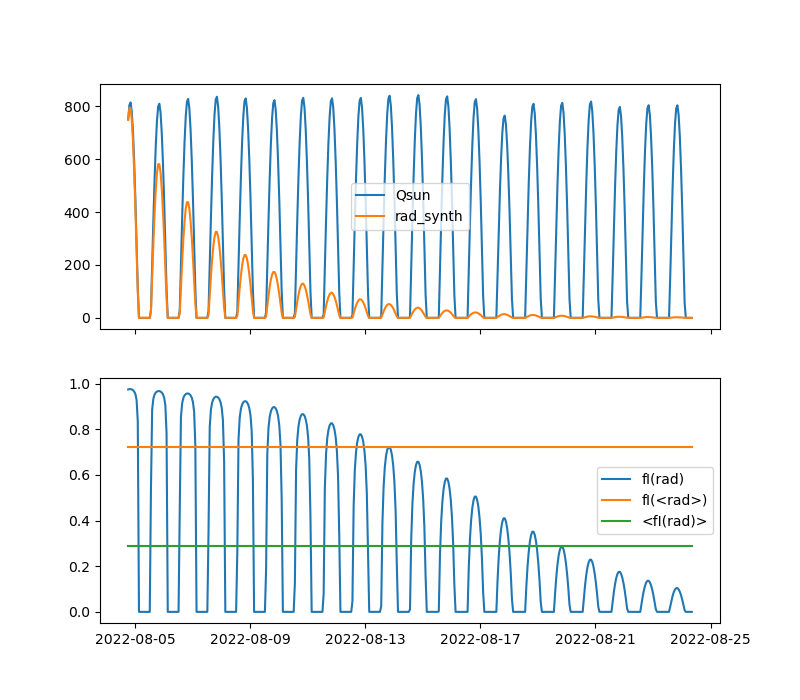

In [68]:
fig,(ax,ax_fI) = plt.subplots(2,1,sharex=True,figsize=(8,7))

ax.plot(ds.time, Qsun, label='Qsun')
ax.plot(ds.time, rad_synth, label='rad_synth')

Isat = 20.0
def fI(I):
    # 0.4
    return I/(I+Isat)

#def fI(I):
#    # 0.443
#    return I/Isat * np.exp(1-I/Isat)

ax_fI.plot(ds.time, fI(rad_synth), label='fI(rad)')
ax_fI.plot(ds.time, np.ones_like(rad_synth) * fI(rad_synth.mean()), label='fI(<rad>)')
ax_fI.plot(ds.time, np.ones_like(rad_synth) * fI(rad_synth).mean(), label='<fI(rad)>')

correction = fI(rad_synth).mean() / fI(rad_synth.mean())
print(f"Correction factor {correction:.3f}")

ax.legend()
ax_fI.legend()

In [302]:
Video(movie_fn) 